__NAME:__ __Venkata Subbaraju Sagi__  
__mail:__ __subbaraju.v@ou.edu__

# Decision Tree Classifiers

### Task
For this Project I will be exploring Decision Tree Classifiers.


### [Data set](https://canvas.ou.edu/courses/163924/files/folder/Homework%20Solutions)

The data file can be found on Canvas under Files/Homework Solutions, and on git and the server under datasets/fraud_detection/health_provider_fraud.csv.  

These data were re-configured from a dataset collected for the purpose of detecting Health care Provider Fraud. Total Medicare spending increases exponentially due to frauds in Medicare claims. Healthcare fraud involves health care providers, physicians, patients, and beneficiaries acting intandum to construct fraudulent claims.

The goal is to "predict potentially fraudulent providers" from summary statistics of their filed healthcare claims. 

__Features__  
The features are aggregate statistics computed as either the mean or the sum.
For the following features, the column is indicative of the average value for the provider's claims:  
* InscClaimAmtReimbursed  
* DeductibleAmtPaid
* NoOfMonths_PartACov
* NoOfMonths_PartBCov
* IPAnnualReimbursementAmt
* IPAnnualDeductibleAmt
* OPAnnualReimbursementAmt
* OPAnnualDeductibleAmt
* NumPhysiciansSeen
* NumProcedures
* NumDiagnosisClaims
* Age
 
For the following features, the column is indicative of the total number among the provider's claims:  
* ChronicCond_Alzheimer  
* ChronicCond_Heartfailure  
* ChronicCond_KidneyDisease  
* ChronicCond_Cancer  
* ChronicCond_ObstrPulmonary  
* ChronicCond_Depression  
* ChronicCond_Diabetes  
* ChronicCond_IschemicHeart  
* ChronicCond_Osteoporasis  
* ChronicCond_rheumatoidarthritis  
* ChronicCond_stroke  
* RenalDiseaseIndicator  

These data were amalagmated from the [HEALTHCARE PROVIDER FRAUD DETECTION ANALYSIS](https://www.kaggle.com/rohitrox/healthcare-provider-fraud-detection-analysis) data set on Kaggle.






In [0]:
# THESE FIRST 3 IMPORTS FROM Python files

import visualize
import metrics_plots
from pipeline_components import DataSampleDropper, DataFrameSelector, DataScaler

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, os, pathlib
import time as timelib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import log_loss, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.externals import joblib
import pickle as pkl

FIGW = 5
FIGH = 5
FONTSIZE = 12

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline
plt.style.use('ggplot')

In [0]:
"""
Display current working directory of this notebook. If you are using 
relative paths for your data, then it needs to be relative to the CWD.
"""
HOME_DIR = pathlib.Path.home()
pathlib.Path.cwd()

PosixPath('/home/jovyan/hw9')

# LOAD DATA

In [0]:
#  set path appropriately. 
# make sure you have the data file path

fname = "health_provider_fraud.csv"
claims_data = pd.read_csv(fname)
claims_data.shape

(5410, 25)

In [0]:
""" 
Display data info
"""
claims_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 25 columns):
Provider                           5410 non-null object
PotentialFraud                     5410 non-null bool
Age                                5410 non-null float64
NumPhysiciansSeen                  5410 non-null float64
NumProcedures                      5410 non-null float64
NumDiagnosisClaims                 5410 non-null float64
InscClaimAmtReimbursed             5410 non-null float64
DeductibleAmtPaid                  5409 non-null float64
NoOfMonths_PartACov                5410 non-null float64
NoOfMonths_PartBCov                5410 non-null float64
IPAnnualReimbursementAmt           5410 non-null float64
IPAnnualDeductibleAmt              5410 non-null float64
OPAnnualReimbursementAmt           5410 non-null float64
OPAnnualDeductibleAmt              5410 non-null float64
ChronicCond_Alzheimer              5410 non-null int64
ChronicCond_Heartfailure           5410 non-

In [0]:
""" 
Display the head of the data
"""
claims_data.head()

,Provider,PotentialFraud,Age,NumPhysiciansSeen,NumProcedures,NumDiagnosisClaims,InscClaimAmtReimbursed,DeductibleAmtPaid,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
0,PRV51001,False,78.840000,1.280000,0.120000,3.640000,4185.600000,213.600000,12.000000,12.000000,...,19,17,5,10,9,21,23,6,8,6
1,PRV51003,True,70.022727,1.181818,0.363636,5.765152,4588.409091,502.166667,11.818182,11.871212,...,80,64,10,41,54,100,112,33,38,12
2,PRV51004,False,72.161074,1.322148,0.000000,2.751678,350.134228,2.080537,11.865772,11.959732,...,88,50,16,41,63,105,108,49,46,17
3,PRV51005,True,70.475536,1.209442,0.000000,2.786266,241.124464,3.175966,11.907296,11.939914,...,680,507,165,295,485,799,895,344,331,124
4,PRV51007,False,69.291667,1.125000,0.013889,3.208333,468.194444,45.333333,11.833333,11.833333,...,40,22,12,16,29,49,51,21,22,12


In [0]:
""" 
Display the summary statistics
Make sure you skim this
"""
claims_data.describe()

,Age,NumPhysiciansSeen,NumProcedures,NumDiagnosisClaims,InscClaimAmtReimbursed,DeductibleAmtPaid,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,...,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke
count,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5409.000000,5410.000000,5410.000000,5410.000000,5410.000000,...,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000
mean,73.731027,1.227410,0.108011,3.676631,1740.679369,155.643175,11.919716,11.930647,6166.692586,666.980865,...,60.921072,42.510906,15.620148,32.288540,44.863956,72.783549,78.341959,32.775231,32.107024,10.495564
std,4.712307,0.220822,0.246305,1.882603,3484.473124,306.489453,0.395682,0.310612,6203.422910,623.108956,...,158.698296,110.048136,41.558020,82.958866,117.563035,190.919202,205.233787,85.862305,84.497824,27.171512
min,34.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,71.768368,1.000000,0.000000,2.696134,232.394593,0.312500,11.994207,11.965836,2902.238095,356.000000,...,6.000000,4.000000,1.000000,3.000000,4.000000,7.000000,7.000000,3.000000,3.000000,1.000000
50%,73.863636,1.200000,0.000000,3.000000,356.085106,4.285714,12.000000,12.000000,4729.047927,527.580008,...,18.000000,13.000000,5.000000,10.000000,13.000000,22.000000,23.000000,10.000000,9.000000,3.000000
75%,75.760000,1.375000,0.083333,3.847902,1490.154301,137.418605,12.000000,12.000000,7336.173195,801.000000,...,52.750000,37.000000,13.000000,29.000000,39.000000,62.750000,67.000000,28.000000,28.000000,9.000000
max,101.000000,3.000000,3.000000,11.000000,57000.000000,1068.000000,12.000000,12.000000,103000.000000,12068.000000,...,4638.000000,3111.000000,1238.000000,2312.000000,3592.000000,5784.000000,6074.000000,2531.000000,2511.000000,810.000000


# PRE-PROCESS DATA

In [0]:
""" 
Construct preprocessing pipeline
"""
selected_features = claims_data.columns
scaled_features = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid',
                   'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                   'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']

pipe = Pipeline([
    ('RowDropper', DataSampleDropper()),
    ('FeatureSelector', DataFrameSelector(selected_features)),
    ('Scale', DataScaler(scaled_features))
])

In [0]:
""" 
Pre-process the data using the defined pipeline
"""
processed_data = pipe.fit_transform(claims_data) # TODO
processed_data.shape

(5409, 25)

In [0]:
""" 
Verify all NaNs removed
"""

pd.DataFrame(processed_data).head

processed_data.isna().any()

Provider                           False
PotentialFraud                     False
Age                                False
NumPhysiciansSeen                  False
NumProcedures                      False
NumDiagnosisClaims                 False
InscClaimAmtReimbursed             False
DeductibleAmtPaid                  False
NoOfMonths_PartACov                False
NoOfMonths_PartBCov                False
IPAnnualReimbursementAmt           False
IPAnnualDeductibleAmt              False
OPAnnualReimbursementAmt           False
OPAnnualDeductibleAmt              False
ChronicCond_Alzheimer              False
ChronicCond_Heartfailure           False
ChronicCond_KidneyDisease          False
ChronicCond_Cancer                 False
ChronicCond_ObstrPulmonary         False
ChronicCond_Depression             False
ChronicCond_Diabetes               False
ChronicCond_IschemicHeart          False
ChronicCond_Osteoporasis           False
ChronicCond_rheumatoidarthritis    False
ChronicCond_stro

# VISUALIZE DATA

False    0.906452
True     0.093548
Name: PotentialFraud, dtype: float64

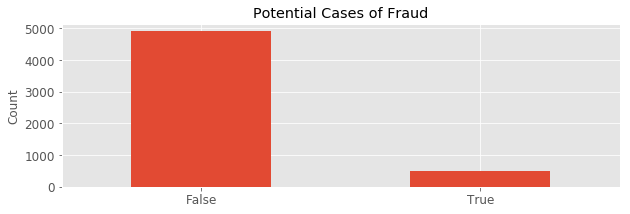

In [0]:
""" 
Plot the class distributions for no potential fraud and potential fraud
"""
class_counts = pd.value_counts(processed_data['PotentialFraud'])
class_counts.plot(kind='bar', rot=0, figsize=(10,3))
plt.title("Potential Cases of Fraud")
plt.ylabel("Count")

# Display the class fractions
nsamples, nfeatures = processed_data.shape
class_counts / nsamples

In [0]:
""" 
Extract positions of the postive and negative cases
"""
pos = processed_data['PotentialFraud'] == 1
neg = processed_data['PotentialFraud'] == 0

FEATURE: PotentialFraud


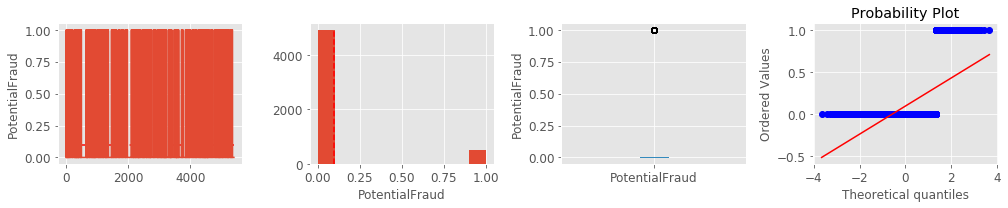

FEATURE: Age


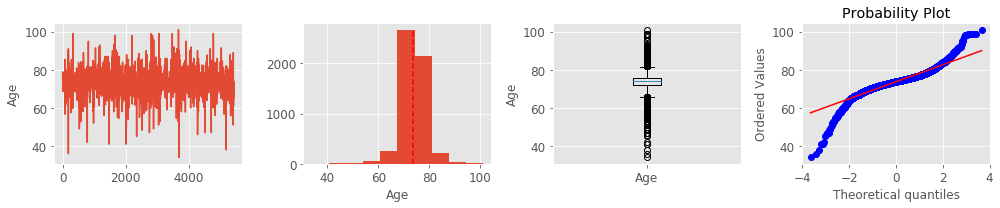

FEATURE: NumPhysiciansSeen


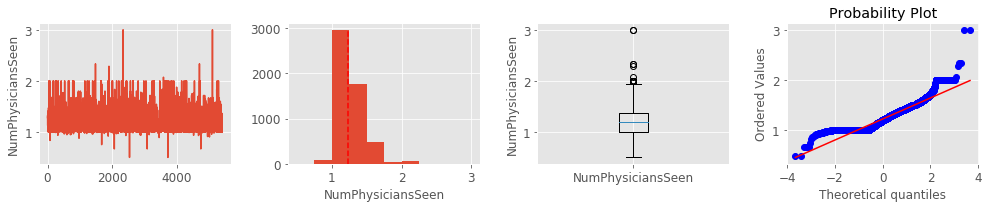

FEATURE: NumProcedures


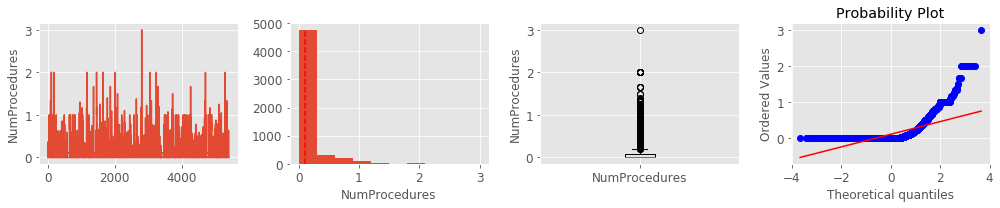

FEATURE: NumDiagnosisClaims


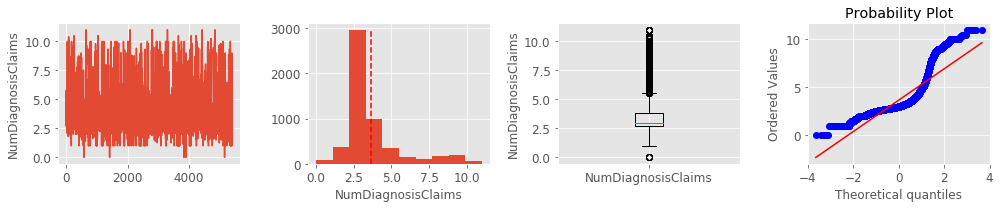

FEATURE: InscClaimAmtReimbursed


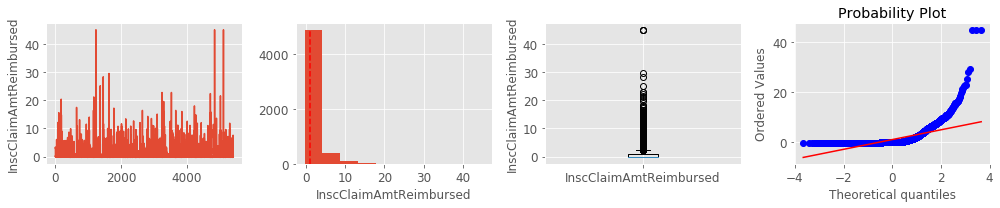

FEATURE: DeductibleAmtPaid


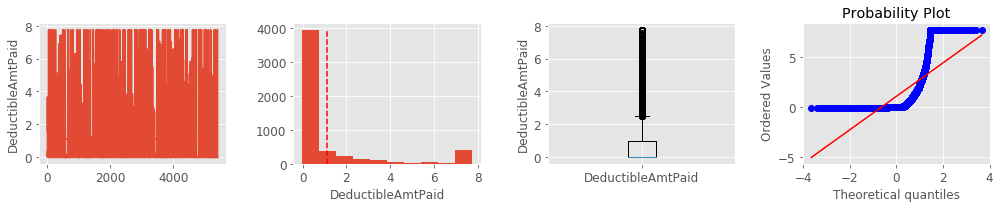

FEATURE: NoOfMonths_PartACov


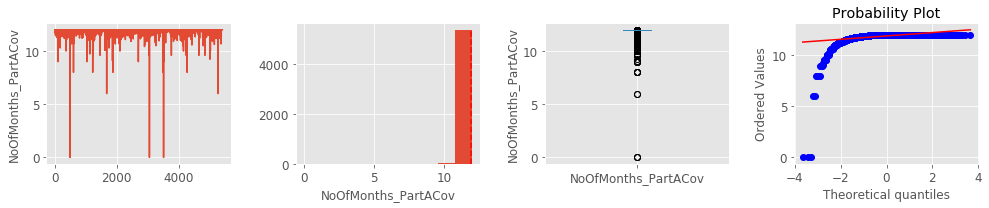

FEATURE: NoOfMonths_PartBCov


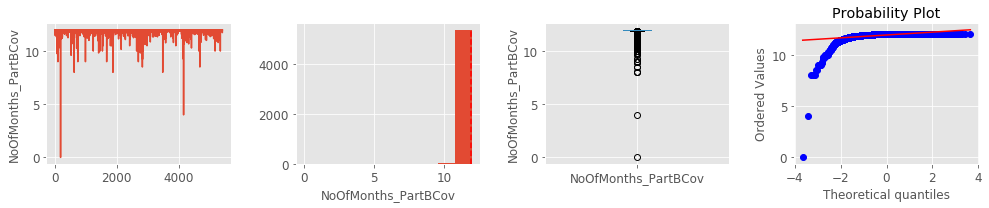

FEATURE: IPAnnualReimbursementAmt


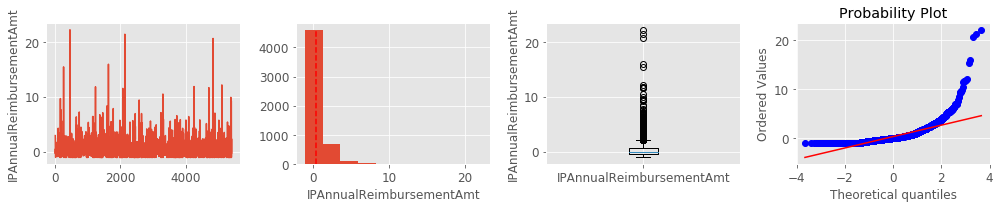

FEATURE: IPAnnualDeductibleAmt


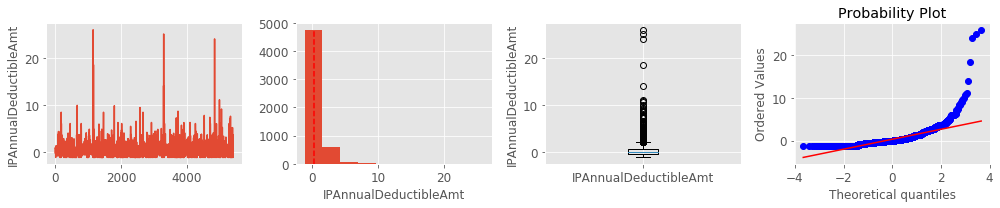

FEATURE: OPAnnualReimbursementAmt


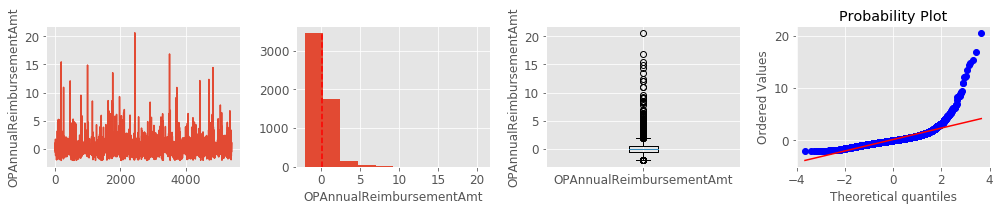

FEATURE: OPAnnualDeductibleAmt


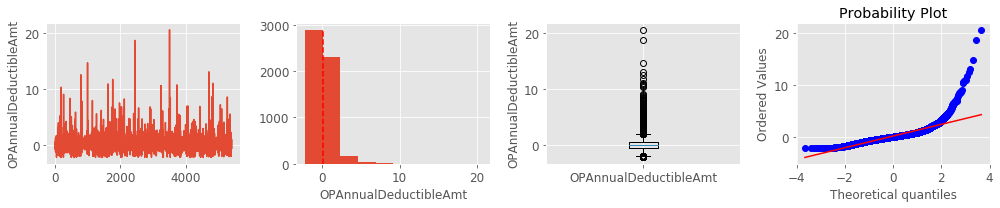

FEATURE: ChronicCond_Alzheimer


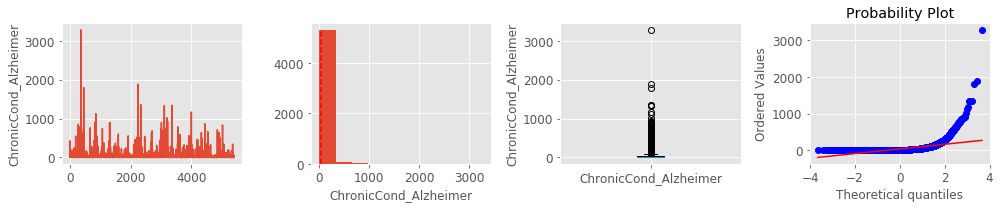

FEATURE: ChronicCond_Heartfailure


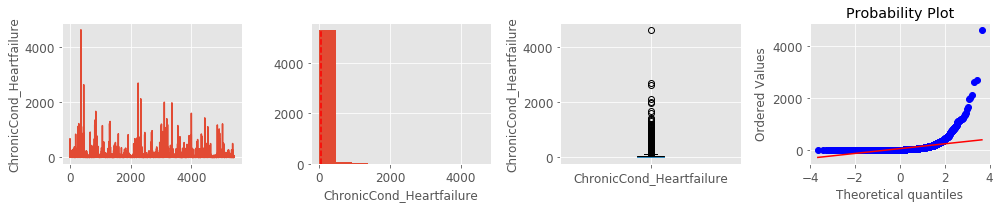

FEATURE: ChronicCond_KidneyDisease


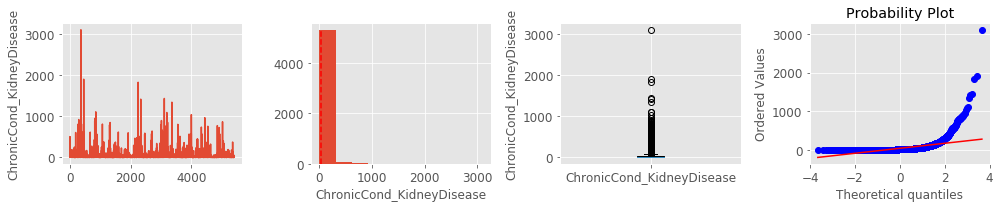

FEATURE: ChronicCond_Cancer


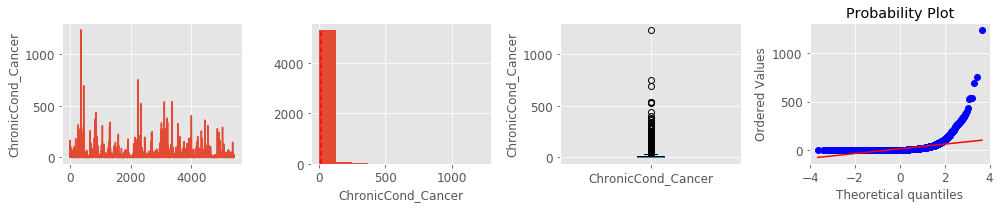

FEATURE: ChronicCond_ObstrPulmonary


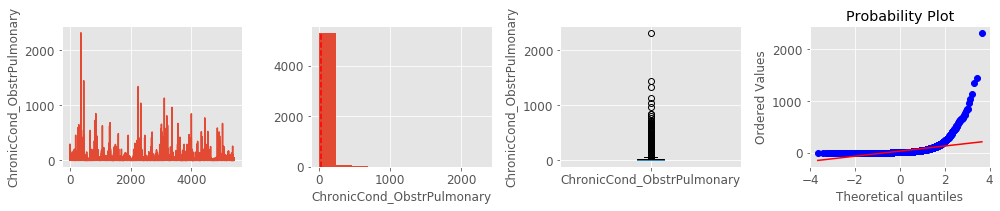

FEATURE: ChronicCond_Depression


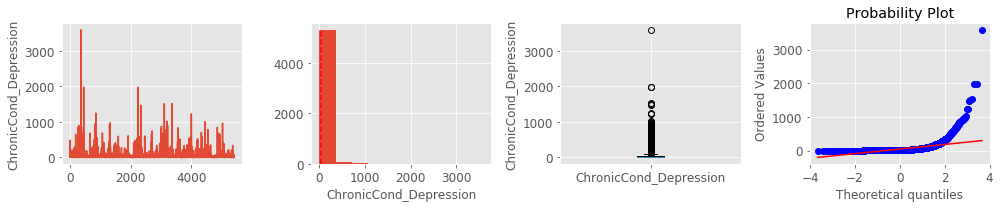

FEATURE: ChronicCond_Diabetes


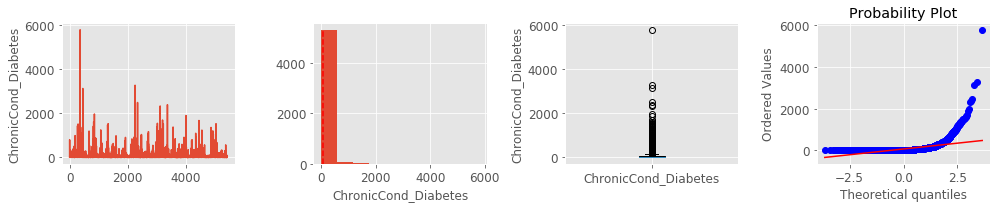

FEATURE: ChronicCond_IschemicHeart


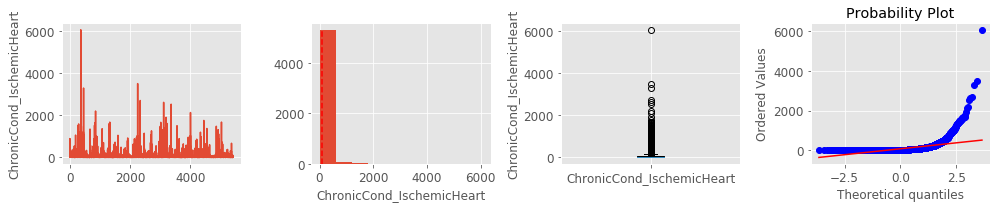

FEATURE: ChronicCond_Osteoporasis


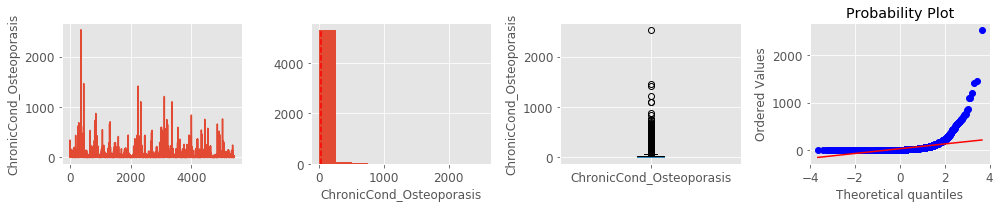

FEATURE: ChronicCond_rheumatoidarthritis


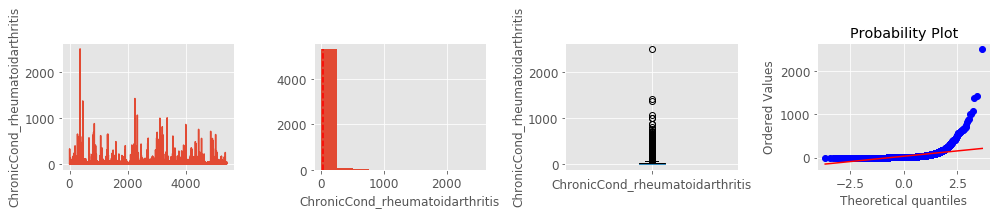

FEATURE: ChronicCond_stroke


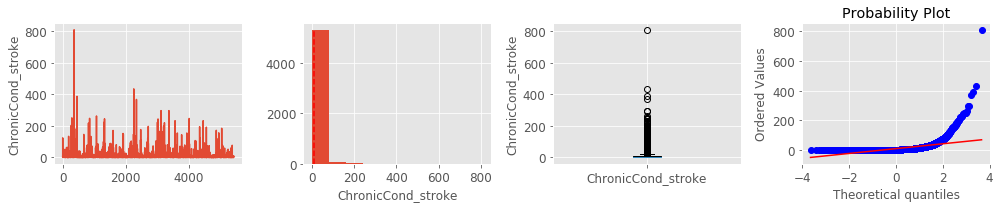

In [0]:
""" 
Visualize the data using visualize.featureplots
"""
# Drop the provider name from the visualized data since it is not numeric
cdata = processed_data.drop(['Provider'], axis=1).astype('float64')
visualize.featureplots(cdata.values, cdata.columns)

# Decision Tree Classifiers

### Model Exploration

In [0]:
""" 
Split data into X (the inputs) and y (the outputs)

Hold out a subset of the data, before training and cross validation
using train_test_split, with stratify NOT equal to None, and a test_size 
fraction of .2.

For this exploratory section, the held out set of data is a validation set.
For the GridSearch section, the held out set of data is a test set.
"""
targetnames = ['NonFraud', 'Fraud']

# TODO: Separate the data into X and y
features = cdata.columns.drop(['PotentialFraud'])

X = cdata[features]

Y = cdata['PotentialFraud']

#check the target names
# TODO: Split data into train and test sets

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, stratify = Y)

x_train.shape,x_test.shape,y_train.shape,y_test.shape




((4327, 23), (1082, 23), (4327,), (1082,))

In [0]:
""" 
Play around with the hyper-parameters. Pick your favorite model 
"""
# TODO: Create and fit the model

decision_tree = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth = 5,max_leaf_nodes = 10)
#decision_tree = DecisionTreeClassifier(criterion='gini', splitter='best',max_depth = 5)
decision_tree.fit(x_train,y_train)
# TODO: Predict with the model on the validation set

y_pred_val = cross_val_predict(decision_tree, x_test, y_test, cv=10)

# TODO: Obtain prediction probabilities for the validation set, using 
# cross_val_predict with cv=10 and method='predict_proba'

probcv = cross_val_predict(decision_tree,x_test,y_test,cv=10,method='predict_proba')

#probcv = 1 - probcv
# TODO: The mean CV accuracy on the given validation data and labels, using 
# cross_val_score and cv=10
scorescv = cross_val_score(decision_tree,x_test,y_test,cv=10)# TODO
np.mean(scorescv)

0.9279461279461281

ROC AUC: 0.834766504173353
PRC AUC: 0.57410142068317
PSS: 0.4142
F1 Score 0.5301


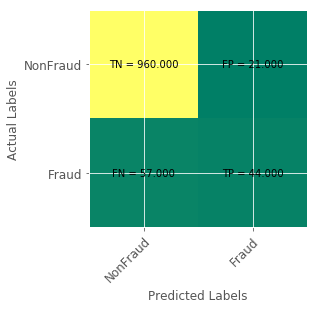

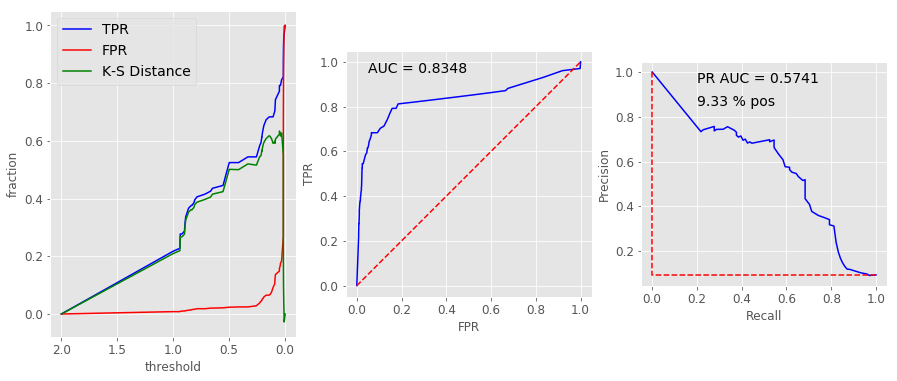

In [0]:
""" 
Display the confusion matrix, KS plot, ROC curve, and PR curve for the validation set
using metrics_plots.ks_roc_prc_plot

The red dashed line in the PRC is indicative of a the expected performance for a random
classifier, which would predict predict postives at the rate of occurance within the data set
"""
# Confusion Matrix

cm = confusion_matrix(y_test,y_pred_val)

fig = metrics_plots.confusion_mtx_colormap(cm,targetnames,targetnames)

#  Curves
# Note, you'll want the probability class predictions for the class label 1

#######################################################################################################

fig = metrics_plots.ks_roc_prc_plot(y_test,probcv[:,1])

# Obtain the PSS and F1 Score
pss_val = metrics_plots.skillScore(y_test, y_pred_val)
f1_val = f1_score(y_test, y_pred_val)
print("PSS: %.4f" % pss_val[0])
print("F1 Score %.4f" % f1_val)

In [0]:
""" 
Export the image of the tree model
use export_graphviz
"""

export_graphviz(decision_tree, out_file='model_best.dot', rounded=True, filled=True)

# GRID SEARCH CV

In [0]:
""" 

Set up and run the grid search using GridSearchCV and the following 
settings:
* The below scoring dictionary for scoring,
* refit set to 'f1' as the optimized metric
* Twenty for the number of cv folds, 
* n_jobs=3, 
* verbose=2, 
* return_train_score=True
"""
classifier = DecisionTreeClassifier()
# Optimized metric
opt_metric = 'f1'
scoring = {opt_metric:opt_metric}

# Flag to re-load previous run regardless of whether the file exists
force = False
# File previous run is saved to
srchfname = "dt_search_" + opt_metric + ".pkl"

# SETUP EXPERIMENT HYPERPARAMETERS
max_depths = [None, 200, 100, 10, 8, 6, 4]
max_leaf_nodes = [None, 10, 5, 2]
criterion = ['gini','entropy']

ndepths = len(max_depths)
nleaves = len(max_leaf_nodes)

#  Create the dictionary of hyper-parameters to try
hyperparams ={'criterion':['gini','entropy'],'splitter':['best','random'],'max_depth':max_depths, 'max_leaf_nodes':max_leaf_nodes, 'class_weight':[None, 'balanced']} # TODO

# RUN EXPERIMENT
time0 = timelib.time()
search = None
if force or (not os.path.exists(srchfname)):
    # TODO: Create the GridSearchCV object
    search = GridSearchCV(classifier,hyperparams,n_jobs = 3,cv = 20,scoring=scoring ,refit = 'f1',verbose = 2,return_train_score=True)# TODO

    # TODO: Execute the grid search by calling fit using the training data
    
    search.fit(x_train,y_train)
    
    # TODO: Save the grid search object
    joblib.dump(search, srchfname)

    print("Saved %s" % srchfname)
else:
    # TODO: Re-load the grid search object
    search = joblib.load(srchfname)
    print("Loaded %s" % srchfname)

time1 = timelib.time()
duration = time1 - time0
print("Elapsed Time: %.2f min" % (duration / 60))

search

Loaded hw9_search_f1.pkl
Elapsed Time: 0.00 min


GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [None, 200, 100, 10, 8, 6, 4], 'max_leaf_nodes': [None, 10, 5, 2], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'f1': 'f1'}, verbose=2)

# RESULTS

In [0]:
""" 
Display the head of the results for the grid search
See the cv_results_ attribute
"""
all_results = search.cv_results_
df_res = pd.DataFrame(all_results)
df_res.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_leaf_nodes,param_splitter,params,...,split12_train_f1,split13_train_f1,split14_train_f1,split15_train_f1,split16_train_f1,split17_train_f1,split18_train_f1,split19_train_f1,mean_train_f1,std_train_f1
0,0.057376,0.008677,0.001606,0.000326,None,gini,None,None,best,"{'class_weight': None, 'criterion': 'gini', 'm...",...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000
1,0.008801,0.001114,0.001437,0.000252,None,gini,None,None,random,"{'class_weight': None, 'criterion': 'gini', 'm...",...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000
2,0.022219,0.003664,0.001405,0.000336,None,gini,None,10,best,"{'class_weight': None, 'criterion': 'gini', 'm...",...,0.620061,0.613003,0.633846,0.585448,0.602151,0.49162,0.637931,0.615147,0.612162,0.037526


In [0]:
""" 
Obtain the best model from the grid search and 
fit it to the full training data
"""

classifier_best = search.best_estimator_
print(search.best_score_)

classifier_best.fit(x_train,y_train)


0.5399510025579488


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [0]:
""" 
Export the image of the best model
use export_graphviz
"""


export_graphviz(classifier_best, out_file='gsearch.dot', rounded=True, filled=True)

mean accuracy0.9288720538720538
ROC AUC: 0.8548359423098272
PRC AUC: 0.5993878969277282
PSS: 0.5379
F1 Score 0.6196


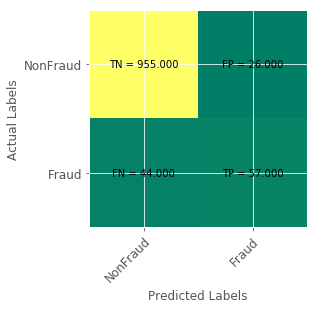

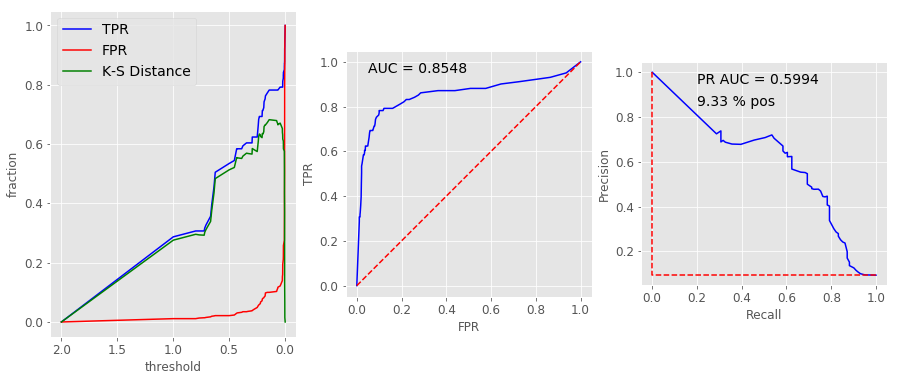

In [0]:
"""
Display the confusion matrix, KS plot, ROC curve, and PR curve for the test 
set using metrics_plots.ks_roc_prc_plot

The red dashed line in the PRC is indicative of a the expected performance for
a random classifier, which would predict predict postives at the rate of 
occurance within the data set
"""
#  Predict with the best model on the test set

gsearch_predict = classifier_best.predict(x_test)


#  Obtain prediction probabilities for the test set using cross_val_predict
# 'predict_proba' as the method

probgs = cross_val_predict(classifier_best,x_test,y_test,cv=10,method='predict_proba')

#probgs = 1 - probgs

#  Compute mean accuracy (using cross_val_score) on the given test data and labels

scorescv = cross_val_score(decision_tree,x_test,y_test,cv=10)# TODO
print(f'mean accuracy{np.mean(scorescv)}')

#  Confusion Matrix
cm_gs = confusion_matrix(y_test,gsearch_predict)

fig = metrics_plots.confusion_mtx_colormap(cm_gs,targetnames,targetnames)


#  Curves (i.e. ROC, PRC, etc) use metrics_plots.ks_roc_prc_plot and the 
# the probabilities for the class label of 1

fig = metrics_plots.ks_roc_prc_plot(y_test,probgs[:,1])

# Obtain the PSS and F1 Score
pss_test = metrics_plots.skillScore(y_test, gsearch_predict)
f1_test = f1_score(y_test, gsearch_predict)
print("PSS: %.4f" % pss_test[0])
print("F1 Score %.4f" % f1_test)

Text(0.5, 1.0, 'Model Probabilities for neg and pos examples')

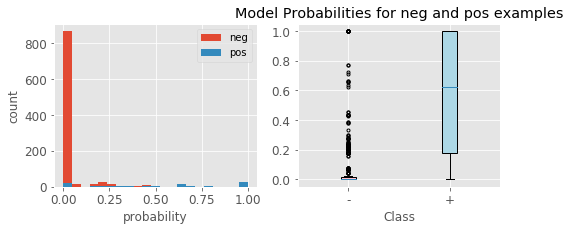

In [0]:
""" 
Plot a histogram of the test scores from the best model.
Compare the distribution of scores for positive and negative examples
using boxplots.

Create one subplot of the distribution of all the scores, with a histogram. 
Create a second subplot comparing the distribution of the scores of the 
positive examples with the distribution of the negative examples, with boxplots.
"""
# Obtain the pos and neg indices
pos_inds = np.where(y_test)[0]
neg_inds = np.where(y_test == 0)[0]

# Separate the scores for the pos and neg examples
proba_pos = probgs[pos_inds, 1]
proba_neg = probgs[neg_inds, 1]

# Plot the distribution of all scores
nbins = 21
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(proba_neg, bins=nbins)
plt.hist(proba_pos, bins=nbins)
plt.xlabel('probability', fontsize=FONTSIZE)
plt.ylabel('count', fontsize=FONTSIZE)
plt.legend(['neg', 'pos'])

# Plot the boxplots of the pos and neg examples
plt.subplot(1,2,2)
boxplot = plt.boxplot([proba_neg, proba_pos], patch_artist=True, sym='.')
boxplot['boxes'][0].set_facecolor('pink')
boxplot['boxes'][1].set_facecolor('lightblue')
plt.xticks(ticks=[1, 2], labels=['-', '+'])
plt.xlabel("Class")
plt.title("Model Probabilities for neg and pos examples")

you can  embed the image of the best tree model into the notebook using:  
`<center><img src="path_to_model.png"  style="width:100%;height:100%">`  




### Histogram and boxplots of the scores.

Checking the Histogram most of our scores for negative examples are close to 0, which shows we are getting better predictions for negative values, But for the positive examples the scores are scattered and some scores give values close to zero, which should not be the ideal case.But considering the fact that we have data unbalancing issue, it might have caused this situation.

Checking the box plot, it shows closer understanding our results from Histogram. The mean value is very much close to 0 for Negative class, since we have many values for negative class which are predicting all right by the model. But the same is not the case for positive example scores, they are all around ranging from 0 to 1, if we can get a model which gives us values closer to one, we can have better predictions from it.

### Test Results: My model

Mean accuracy:0.9279461279461281

ROC AUC: 0.834766504173353 

PRC AUC: 0.57410142068317 

PSS: 0.4142 

F1 Score 0.5301

TN: 960, FP:21, FN:57,TP:44

### Test Result : GridSearch

mean accuracy0.9288720538720538 

ROC AUC: 0.8548359423098272 

PRC AUC: 0.5993878969277282 

PSS: 0.5379 

F1 Score 0.6196

TN: 955, FP:26, FN:44,TP:57

I have Improvement in my Test results For Grid Search. Eventhough the values did not change a lot, it can be seen that the values have improved.

Both ROC AUC and PRC AUC have improved for Grid Search.
as the classifier is predicting more points that belong to positves,we are getting better results for grid search.It is same with PRC AUC value too.
True Negatives are pretty close for both the models. The error values are reduced for grid search.
F1 score also improved for Grid Search.

From these results we can see that Grid search is doing really well with our data, but in our data there are more negative examples than the positive ones, that is the reason we have relatively low PRC AUC values compared to ROC AUC. Prediction of negative values was way higher than that of positive values prediction.

On whole I still would like to see values of PRC AUC close to 1. But comparing the both models, i can say that GridSearch gives me better results, than my selected model.

I have not used proper hyperparameters in my inital model,I think Having better Hyperparameters gave me better results.
I even observed that different splits in training data generated very different trees. And I see that Decision tree is not very accurate for this particular problem.

#### My final model Decision Tree

![model_best](model_best.png)

In [0]:
<center>
<img src="model_best.png" style="width:100%;height:100%">

#### Grid Search Decision Tree

<center>
<img src="gsearch.png" style="width:100%;height:100%">

![gsearch](gsearch.png)

 ### Comparing the best model from the grid search to the one I chose in the exploration section

It can be clearly seen that my Initial model generates a DecisionTree that is Unbalanced, but is giving me pretty good results.I have used Max_depth= 5 for my model, in the Grid Search I see that I get to have a max_deph to be 4, so the splitting of the tree is done accordingly.

For my model, I have selected Gini Impurity, In the Grid Search entropy was taken as the Criterian.

First two levels of  my model, has better balance, but after that they are handling much more exceptions.Gini Scores are more diverse for my model, so from just the visualization i think we need better structure.

Coming to the Grid Search, we have entropy values, which are again not very close, they are diverse but we get to see better results as entropy closes to zero in most of the cases, which makes the prediction easier.Certainly Model can perform better.

In both the Model Feature 2(NumProcedures) was selected to have highest Feature Importance than other Feaures, that can seen in both the trees as This feature was selected at early level of the tree. Just by looking at the split levels, we can get an idea of feaures chosen at that particular level will be having higher importance than other fetures.
